In [41]:
# =============================================================================
# Created By:     Kai Metzger
# Created School: Franz-Oberthuer-Schule Wuerzburg
# Created Email:  metzgerkai@franz-oberthuer-schule.de
# Created Date:   Sat April 05 09:54 UTC 2025
# Version:        1.0.1
# =============================================================================
"""The Module has been build for training the symbols dataset with images + 
ground truth on a Raspberry Pi 5 with a standard USB camera. An image with a 
resolution of 640px x 480px can be recorded with the Python script 
create-symbols-dataset.py.
The files in the dataset <symbols> should be ordered in the following
manner:             > explanation
- symbols      
  - dataset1        > dataset version (dataset1 - 3 where used in the project)
    - data          > images (.png files)
    - gt            > ground truth (.txt files with class labels 1-4)
"""

# pip install keras-tuner --upgrade

# =============================================================================
# Import
# =============================================================================
import cv2
import os
import numpy as np
from keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import keras_tuner as kt
import keras
import tensorflow as tf

# Enable Nvidia GPUs by un-commenting this line 
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
XLA_FLAGS="--xla_gpu_cuda_data_dir=/usr/"

# To get reproducable results with the same training setting random seed
SEED = 42
np.random.seed(SEED)
keras.utils.set_random_seed = SEED
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [42]:
# =============================================================================
# Declare variables
# =============================================================================
img_size_x = 32
img_size_y = 32
img_dim = img_size_x * img_size_y

# Change the following paths to your dataset path
home_dir = os.path.expanduser("~")
dataset_for_training = "dataset8"
img_dir = home_dir + "/ml_project/datasets/symbols/" + dataset_for_training + "/data"
gt_dir = home_dir + "/ml_project/datasets/symbols/" + dataset_for_training + "/gt"
checkpoint_filepath = home_dir + "/ml_project/datasets/symbols/" + dataset_for_training + "/chpt/"

print("image vector size:", img_dim)
#print(img_dir)

image vector size: 1024


In [43]:
# =============================================================================
# Get number of data (image/label) 
# =============================================================================
anz_data = len(os.listdir(img_dir))
anz_data = int(anz_data)
dataset = np.zeros((anz_data, img_size_x, img_size_y), dtype=float)
ground_truth = np.zeros((anz_data), dtype=int)
print("dataset size:", anz_data)

dataset size: 700


In [44]:
# =============================================================================
# Define functions
# =============================================================================
# Change image size and convert to grayscale images
def pic_prep (image, x, y):
  image = cv2.resize(image, (y,x))                # change image size
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to grayscale
  image = image / 255                             # image normalization
  return image

# Shuffle images
def unison_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


In [45]:
# =============================================================================
# Callback for training
# =============================================================================
# Set verbose flag to 0 to omit loss/accuracy output per epoch
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath + "chpt.keras",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True,
    verbose = 1)

In [46]:
# =============================================================================
# Read dataset
# =============================================================================
for i in range(0, anz_data, 1):
    img_name = img_dir + '/' + str(i) + '.png'      # create file names
    image = cv2.imread(img_name)                    # read image
    image = pic_prep(image, img_size_x, img_size_y) # prepare image
    dataset[i,:,:] = image                          # 2d-image to 3d-array
    
    txt_name = gt_dir + '/' + str(i) + '.txt'       # create gt file names
    ground_truth[i] = np.genfromtxt(txt_name, delimiter=',') 

In [47]:
# =============================================================================
# Prepare dataset: train set (80%) and test set (20%)
# =============================================================================
print("shape dataset", dataset.shape)
#dataset = dataset.reshape(anz_data, img_dim) # convert into 2d array (all pixel in one row)
#print("shape dataset", dataset.shape)
#ground_truth = ground_truth.reshape(anz_data, 1)

dataset, ground_truth = unison_shuffle(dataset, ground_truth)

trainset = np.random.choice(dataset.shape[0],
                            int(dataset.shape[0]*0.80), 
                            replace=False)
train_data = dataset[trainset,:]
train_gt = ground_truth[trainset]
#train_gt = utils.to_categorical(train_gt, 4)

testset = np.delete(np.arange(0, len(ground_truth) ), 
                    trainset) 
test_data = dataset[testset,:]
test_gt = ground_truth[testset]
#test_gt = utils.to_categorical(test_gt, 4)

print(ground_truth.shape)
print(dataset.shape)

print(trainset.shape)
print(train_data.shape)
print(train_gt.shape)

shape dataset (700, 32, 32)
(700,)
(700, 32, 32)
(560,)
(560, 32, 32)
(560,)


In [48]:
# =============================================================================
# Create neural network with 4 layers and (in=32x32, 32-512, out=4) neurons per layer.
# =============================================================================
def model_builder(hp):

  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(32, 32)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))

  model.add(keras.layers.Dense(4))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model


## Keras Tuner

From: https://www.tensorflow.org/tutorials/keras/keras_tuner

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='symbols_tuning',
                     project_name='symbols_tuning')


## Early stopping:

Create a callback to stop training early after reaching a certain value for the validation loss.

In [50]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


## Hyperparameter search
Run the hyperparameter search. The arguments for the search method are the same as those used for tf.keras.model.fit in addition to the callback above.


In [51]:
tuner.search(train_data, train_gt, epochs=200, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Trial 30 Complete [00h 00m 04s]
val_accuracy: 0.2946428656578064

Best val_accuracy So Far: 0.3571428656578064
Total elapsed time: 00h 01m 45s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 480 and the optimal learning rate for the optimizer
is 0.001.



## Train the model
Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 200 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_data, train_gt, epochs=200, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Epoch 1/200


/home/pi/ml_project/.venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2635 - loss: 3.1457

2025-04-08 19:58:04.846311: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.2644 - loss: 3.1107 - val_accuracy: 0.3214 - val_loss: 1.8808
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2581 - loss: 1.8588 - val_accuracy: 0.3214 - val_loss: 1.6701
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2672 - loss: 1.5940 - val_accuracy: 0.2054 - val_loss: 1.8139
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.2360 - loss: 1.5706 - val_accuracy: 0.1964 - val_loss: 1.6752
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2310 - loss: 1.5236 - val_accuracy: 0.1964 - val_loss: 1.6441
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2703 - loss: 1.5013 - val_accuracy: 0.1964 - val_loss: 1.6313
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2899 - loss: 1.4824 - val_accuracy: 0.1964 - val_loss: 1.6076
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2989 - loss: 1.4693 - val_accuracy: 0.1964 - val_l

## Train again :-)
Re-instantiate the hypermodel and train it with the optimal number of epochs from above.



In [54]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_data, train_gt, epochs=best_epoch, validation_split=0.2)


Epoch 1/90


/home/pi/ml_project/.venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2551 - loss: 2.8352

2025-04-08 20:00:28.118754: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.2540 - loss: 2.8104 - val_accuracy: 0.2679 - val_loss: 2.0437
Epoch 2/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2670 - loss: 1.7289 - val_accuracy: 0.2054 - val_loss: 1.8544
Epoch 3/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2264 - loss: 1.6138 - val_accuracy: 0.2143 - val_loss: 1.6482
Epoch 4/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2477 - loss: 1.5258 - val_accuracy: 0.2054 - val_loss: 1.6608
Epoch 5/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.2248 - loss: 1.5188 - val_accuracy: 0.2054 - val_loss: 1.6503
Epoch 6/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2721 - loss: 1.5113 - val_accuracy: 0.2054 - val_loss: 1.6285
Epoch 7/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2994 - loss: 1.4965 - val_accuracy: 0.2054 - val_loss: 1.6234
Epoch 8/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2916 - loss: 1.4935 - val_accuracy: 0.1964 - val_loss: 1.

### To finish this tutorial, evaluate the hypermodel on the test data.



In [56]:
eval_result = hypermodel.evaluate(test_data, test_gt)
print("[test loss, test accuracy]:", eval_result)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4972 - loss: 1.1682
[test loss, test accuracy]: [1.1682510375976562, 0.5071428418159485]


2025-04-08 20:01:45.105559: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


In [ ]:
exit()

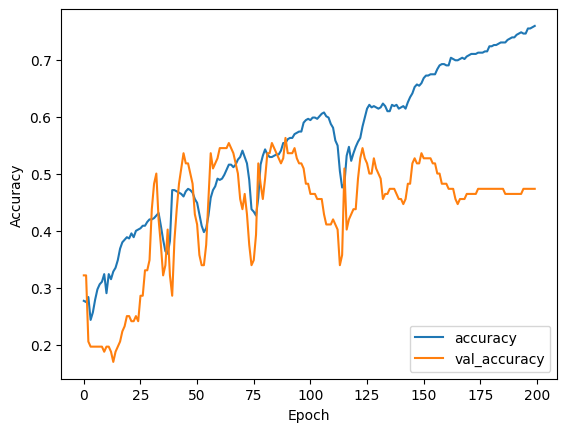

In [58]:
# =============================================================================
# Plot train and val accuracy.
# =============================================================================

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


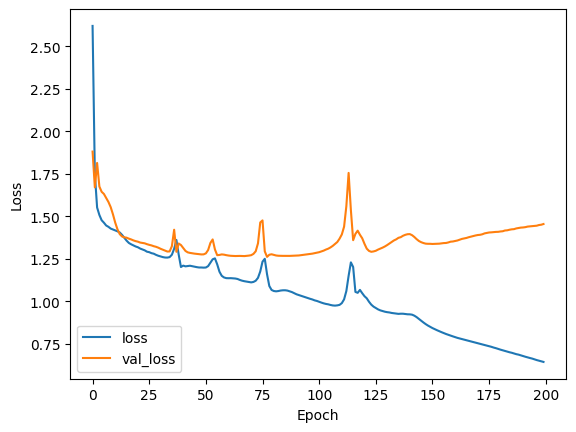

In [60]:
# =============================================================================
# Plot train and val loss.
# =============================================================================

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.show()

In [ ]:
exit()

: 

In [ ]:
# =============================================================================
# Load pretrained dataset weights to e.g. test on new (unseen) data.
# =============================================================================
model.load_weights(checkpoint_filepath + "chpt.keras")

In [ ]:
# =============================================================================
# Test dataset on xxx.
# =============================================================================
score = model.evaluate(test_data, test_gt, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# =============================================================================
# Testing on a single image.
# =============================================================================
data_pred = np.zeros((1, img_size_x, img_size_y), dtype=float)
img_pred = cv2.imread(home_dir + "/ml_project/datasets/symbols/" + dataset_for_training + "/data/14.png")
img_pred = pic_prep(img_pred, img_size_x, img_size_y)
data_pred[0,:,:] = img_pred
data_pred = data_pred.reshape(1,img_dim)
result = model.predict(data_pred)
result = np.round(result, decimals=2)

print("Probability for classes: (cross, circle, triangle, square) in percent", 
      result)

In [ ]:
# =============================================================================
# Output class: 
# translate class label (0,1,2,3) to class (cross, circle, triangle, square).
# =============================================================================

max_res = 0
res_index = 4
for i in range(0, 4, 1):
    if result[0,i] > max_res:
        max_res = result[0,i]
        res_index = i

if res_index == 0:
    print('Cross detected!')
elif res_index == 1:
    print('Circle detected!')
elif res_index == 2:
    print('Triangle detected!')
elif res_index == 3:
    print('Square detected!')
elif res_index == 4:
    print('Error!')